In [43]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
%autoreload 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

import utilities as ut

from scipy.stats import sem
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Load FE data


In [45]:
data_path = 'training_data/hourly_mean/'
save_path = 'xgboost_models/'

In [46]:
y_train = pd.read_csv(f'{data_path}y_train_A.csv')
X_train = pd.read_csv(f'{data_path}/X_train_selected_A.csv')
X_test = pd.read_csv(f'{data_path}/X_test_selected_A.csv')

y_train = y_train.set_index('date_forecast')
y_train.index = pd.to_datetime(y_train.index)

X_train = X_train.set_index('date_forecast')
X_train.index = pd.to_datetime(X_train.index)

X_test = X_test.set_index('date_forecast')
X_test.index = pd.to_datetime(X_test.index)

In [47]:
y_train

,pv_measurement
date_forecast,
2019-06-02 22:00:00,0.00
2019-06-02 23:00:00,0.00
2019-06-03 00:00:00,0.00
2019-06-03 01:00:00,0.00
2019-06-03 02:00:00,19.36
...,...
2023-04-30 19:00:00,9.02
2023-04-30 20:00:00,0.00
2023-04-30 21:00:00,0.00


In [48]:
X_test

,temp_solar_interaction,clear_sky_rad:W,sun_zenith:d,sun_azimuth:d,sun_equation_of_time,wind_speed_u_10m:ms,sfc_pressure:hPa,solar_radiation_ratio,dew_point_2m:K,ceiling_height_agl:m,day,visibility:m,wind_speed_magnitude,temp_dewpoint_diff,day_of_year,total_cloud_cover:p,air_density_2m:kgm3,is_day:idx
date_forecast,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,0.0,0.0,101.166019,10.520,2.806174,2.2,1013.3,NaN,271.7,912.7,1,30210.7,4.049691,-2.1,121,80.7,1.286,0.0
2023-05-01 00:15:00,0.0,0.0,100.792356,14.203,2.807480,2.1,1013.2,NaN,271.7,912.7,1,30003.6,3.996248,-2.1,121,77.0,1.287,0.0
2023-05-01 00:30:00,0.0,0.0,100.314960,17.869,2.808785,2.1,1013.0,NaN,271.6,912.7,1,29797.1,3.911521,-2.2,121,73.1,1.287,0.0
2023-05-01 00:45:00,0.0,0.0,99.736307,21.514,2.810090,2.0,1012.9,NaN,271.6,912.7,1,29618.6,3.858756,-2.2,121,69.0,1.287,0.0
2023-05-01 01:00:00,0.0,0.0,99.059338,25.135,2.811393,2.0,1012.8,NaN,271.6,NaN,1,29507.5,3.858756,-2.2,121,64.5,1.287,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 22:45:00,0.0,0.0,93.333591,351.856,-4.315167,1.7,992.6,NaN,282.7,2090.6,3,39931.6,2.140093,-2.7,184,99.4,1.207,0.0
2023-07-03 23:00:00,0.0,0.0,93.538016,355.318,-4.317044,1.6,992.7,NaN,282.7,2015.8,3,39574.3,2.061553,-2.6,184,100.0,1.207,0.0
2023-07-03 23:15:00,0.0,0.0,93.641724,358.785,-4.318920,1.6,992.8,NaN,282.7,2015.7,3,39627.2,2.000000,-2.6,184,100.0,1.208,0.0


## Train and fit model

In [49]:
gbm = XGBRegressor()
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=1)
reg_cv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [1.0], 'max_depth': [3, 4, 6],
                         'min_child_weight': [1.0, 1.2],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [50]:
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.0,
 'n_estimators': 500}

In [51]:
reg = XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Make prediction

In [52]:
reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 1.0,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

([<matplotlib.axis.XTick at 0x7f160c7a1c90>,
 [Text(0, 0, 'temp_solar_interaction'),
  Text(1, 0, 'clear_sky_rad:W'),
  Text(2, 0, 'sun_azimuth:d'),
  Text(3, 0, 'sun_zenith:d'),
  Text(4, 0, 'solar_radiation_ratio'),
  Text(5, 0, 'day_of_year'),
  Text(6, 0, 'wind_speed_u_10m:ms'),
  Text(7, 0, 'visibility:m'),
  Text(8, 0, 'dew_point_2m:K'),
  Text(9, 0, 'sfc_pressure:hPa'),
  Text(10, 0, 'total_cloud_cover:p'),
  Text(11, 0, 'sun_equation_of_time'),
  Text(12, 0, 'ceiling_height_agl:m'),
  Text(13, 0, 'day'),
  Text(14, 0, 'air_density_2m:kgm3'),
  Text(15, 0, 'wind_speed_magnitude'),
  Text(16, 0, 'temp_dewpoint_diff'),
  Text(17, 0, 'is_day:idx')])

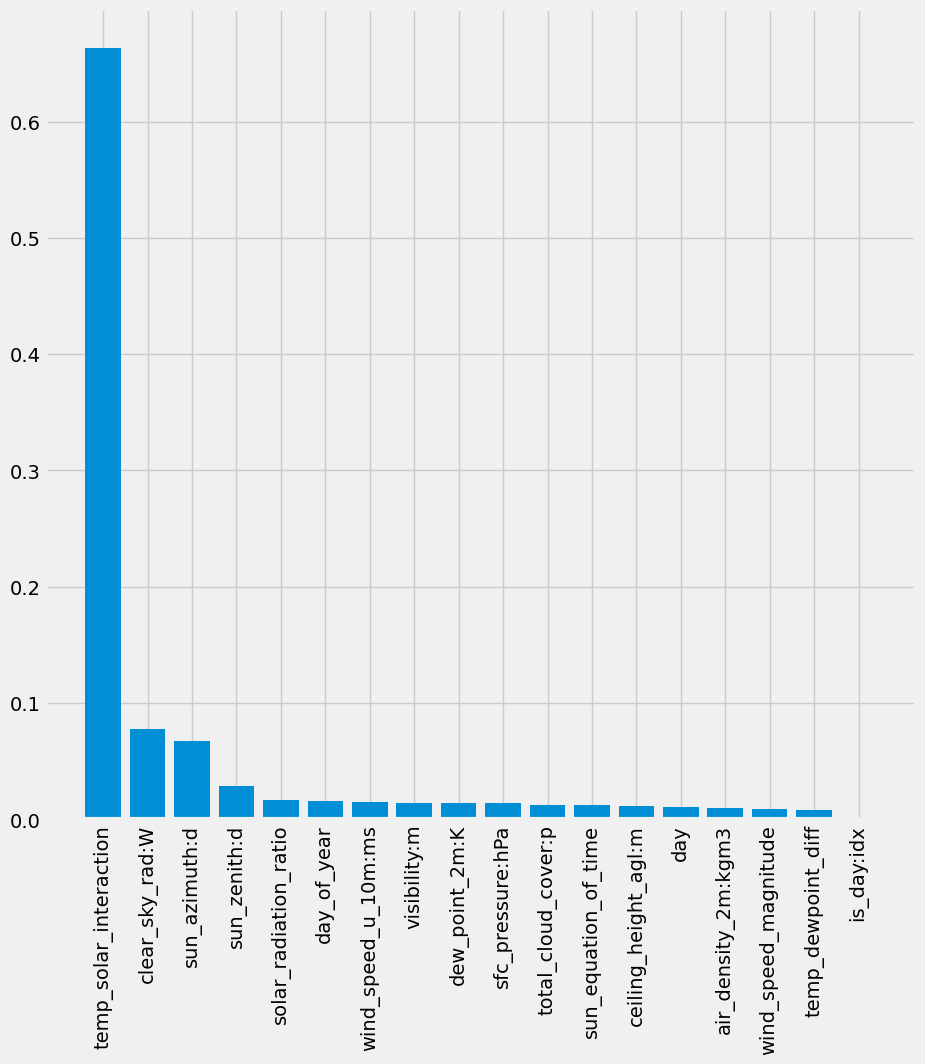

In [53]:
# get the feature importance
importance = reg.feature_importances_
# get their names and put in a list
feature_names = X_train.columns
# sort in descending order
index_sorted = np.argsort(importance)[::-1]
# create tick labels
tick_labels = np.array(feature_names)[index_sorted]
# plot
plt.figure(figsize=(10,10))
plt.bar(range(X_train.shape[1]), importance[index_sorted])
plt.xticks(range(X_train.shape[1]), tick_labels, rotation=90)

In [54]:
X_test

,temp_solar_interaction,clear_sky_rad:W,sun_zenith:d,sun_azimuth:d,sun_equation_of_time,wind_speed_u_10m:ms,sfc_pressure:hPa,solar_radiation_ratio,dew_point_2m:K,ceiling_height_agl:m,day,visibility:m,wind_speed_magnitude,temp_dewpoint_diff,day_of_year,total_cloud_cover:p,air_density_2m:kgm3,is_day:idx
date_forecast,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,0.0,0.0,101.166019,10.520,2.806174,2.2,1013.3,NaN,271.7,912.7,1,30210.7,4.049691,-2.1,121,80.7,1.286,0.0
2023-05-01 00:15:00,0.0,0.0,100.792356,14.203,2.807480,2.1,1013.2,NaN,271.7,912.7,1,30003.6,3.996248,-2.1,121,77.0,1.287,0.0
2023-05-01 00:30:00,0.0,0.0,100.314960,17.869,2.808785,2.1,1013.0,NaN,271.6,912.7,1,29797.1,3.911521,-2.2,121,73.1,1.287,0.0
2023-05-01 00:45:00,0.0,0.0,99.736307,21.514,2.810090,2.0,1012.9,NaN,271.6,912.7,1,29618.6,3.858756,-2.2,121,69.0,1.287,0.0
2023-05-01 01:00:00,0.0,0.0,99.059338,25.135,2.811393,2.0,1012.8,NaN,271.6,NaN,1,29507.5,3.858756,-2.2,121,64.5,1.287,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 22:45:00,0.0,0.0,93.333591,351.856,-4.315167,1.7,992.6,NaN,282.7,2090.6,3,39931.6,2.140093,-2.7,184,99.4,1.207,0.0
2023-07-03 23:00:00,0.0,0.0,93.538016,355.318,-4.317044,1.6,992.7,NaN,282.7,2015.8,3,39574.3,2.061553,-2.6,184,100.0,1.207,0.0
2023-07-03 23:15:00,0.0,0.0,93.641724,358.785,-4.318920,1.6,992.8,NaN,282.7,2015.7,3,39627.2,2.000000,-2.6,184,100.0,1.208,0.0


In [55]:
predictions = reg.predict(X_test)

In [56]:
predictions

array([-59.529934, -59.529934, -64.66796 , ..., -38.61243 , 360.74066 ,
       361.88812 ], dtype=float32)

In [57]:
# convert to pandas dataframe
predictions = pd.DataFrame(predictions, columns=['prediction'])
# set the index to datetime
predictions.index = X_test.index


In [58]:
# set all negative values to zero
predictions[predictions < 0] = 0
predictions.describe()

,prediction
count,2880.000000
mean,1312.576538
std,1409.232300
min,0.000000
25%,171.895931
50%,769.720276
75%,2138.970825
max,5846.637695


In [59]:
predictions

,prediction
date_forecast,
2023-05-01 00:00:00,0.000000
2023-05-01 00:15:00,0.000000
2023-05-01 00:30:00,0.000000
2023-05-01 00:45:00,0.000000
2023-05-01 01:00:00,0.000000
...,...
2023-07-03 22:45:00,0.000000
2023-07-03 23:00:00,0.000000
2023-07-03 23:15:00,0.000000


<Axes: xlabel='date_forecast'>

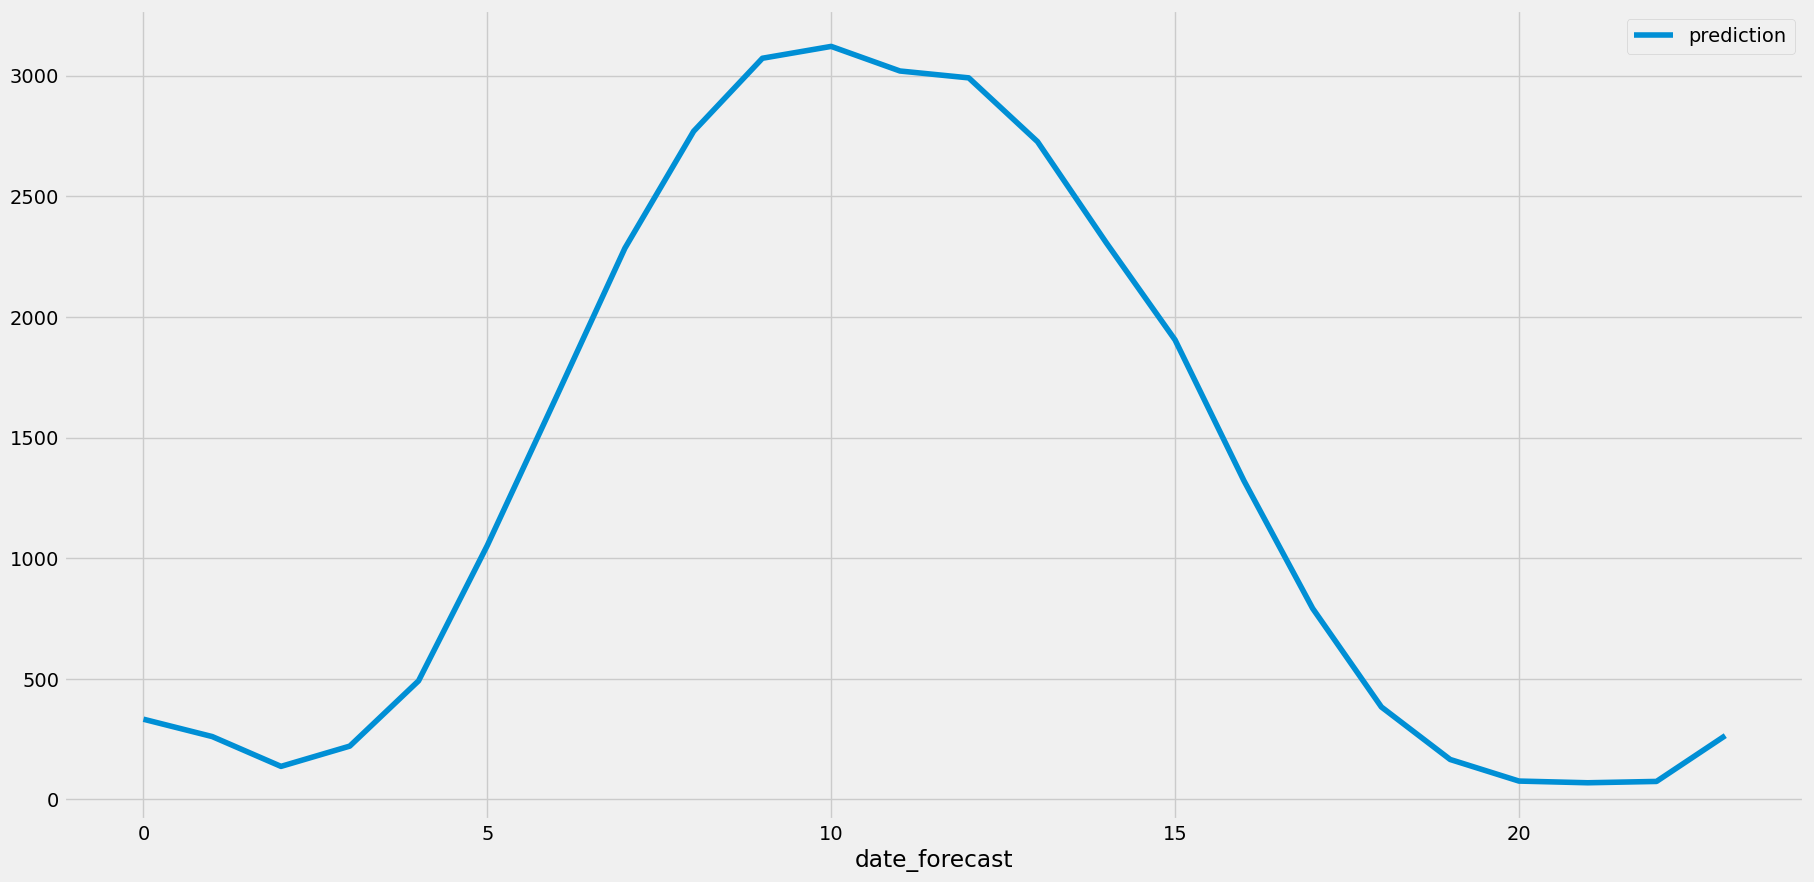

In [60]:
# show the pv_prediction average dsiutribution per hour
predictions.groupby(predictions.index.hour).mean().plot(figsize=(20,10))

In [61]:
pickle.dump(reg, open(f'{save_path}xgbregressor_hourly_mean_A.pickle.dat', 'wb'))